In [1]:
import sqlite3
import pandas as pd
import numpy as np
import os
import scipy.stats as stats
from scipy.stats import ttest_1samp
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
con=sqlite3.connect('data/im.db')
cursor_obj=con.cursor()
cursor_obj

In [3]:
%%bash
sqlite3 data/im.db
.schema

CREATE TABLE IF NOT EXISTS "movie_basics" (
"movie_id" TEXT,
  "primary_title" TEXT,
  "original_title" TEXT,
  "start_year" INTEGER,
  "runtime_minutes" REAL,
  "genres" TEXT
);
CREATE TABLE IF NOT EXISTS "directors" (
"movie_id" TEXT,
  "person_id" TEXT
);
CREATE TABLE IF NOT EXISTS "known_for" (
"person_id" TEXT,
  "movie_id" TEXT
);
CREATE TABLE IF NOT EXISTS "movie_akas" (
"movie_id" TEXT,
  "ordering" INTEGER,
  "title" TEXT,
  "region" TEXT,
  "language" TEXT,
  "types" TEXT,
  "attributes" TEXT,
  "is_original_title" REAL
);
CREATE TABLE IF NOT EXISTS "movie_ratings" (
"movie_id" TEXT,
  "averagerating" REAL,
  "numvotes" INTEGER
);
CREATE TABLE IF NOT EXISTS "persons" (
"person_id" TEXT,
  "primary_name" TEXT,
  "birth_year" REAL,
  "death_year" REAL,
  "primary_profession" TEXT
);
CREATE TABLE IF NOT EXISTS "principals" (
"movie_id" TEXT,
  "ordering" INTEGER,
  "person_id" TEXT,
  "category" TEXT,
  "job" TEXT,
  "characters" TEXT
);
CREATE TABLE IF NOT EXISTS "writers" (
"m

In [4]:
q1=\
"""
SELECT
    movie_id,
    primary_title,
    original_title,
    start_year,
    runtime_minutes,
    genres,
    ordering,
    title,
    region,
    language,
    types,
    attributes,
    is_original_title,
    averagerating,
    numvotes

FROM (
    SELECT
        movie_id,
        primary_title,
        original_title,
        start_year,
        runtime_minutes,
        genres,
        ordering,
        title,
        region,
        language,
        types,
        attributes,
        is_original_title
    FROM
        movie_basics
    JOIN
        movie_akas
    USING (movie_id)
        ) as movie_info
JOIN movie_ratings

USING (movie_id)

"""
movie_info=pd.read_sql(q1, con)

In [5]:
movie_info[0:10]

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,ordering,title,region,language,types,attributes,is_original_title,averagerating,numvotes
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",1,Sangharsh,IN,hi,None,alternative transliteration,0.0,7.0,77
1,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",2,Sunghursh,None,None,original,None,1.0,7.0,77
2,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",3,Sunghursh,IN,None,None,None,0.0,7.0,77
3,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",4,Sunghursh,IN,hi,None,alternative transliteration,0.0,7.0,77
4,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",5,Sungharsh,IN,hi,None,alternative spelling,0.0,7.0,77
5,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama",1,One Day Before the Rainy Season,XWW,en,None,None,0.0,7.2,43
6,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama",2,Ashad Ka Ek Din,IN,None,None,None,0.0,7.2,43
7,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama",3,One Monsoon Day,None,None,None,None,0.0,7.2,43
8,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama",4,Ashad Ka Ek Din,None,None,original,None,1.0,7.2,43
9,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama,1,O Outro Lado do Vento,BR,None,imdbDisplay,None,0.0,6.9,4517


In [6]:
WW_cleaned=pd.read_csv('WW_cleaned_tiered.csv')

In [7]:
q4=\
"""
SELECT 
    movie_id,
    principals.person_id as principal_id,
    category,
    primary_name as principal_primary_name,
    birth_year as principal_birth_year,
    death_year as principal_death_year

FROM principals
LEFT JOIN persons 
ON principals.person_id=persons.person_id    
"""
principals_info=pd.read_sql(q4, con)

In [8]:
principals_info=principals_info.drop_duplicates()
movie_w_principal_info=pd.merge(movie_info, principals_info, on = 'movie_id', how = 'inner')
movie_w_principal_info=movie_w_principal_info.drop(columns=['ordering','title','region','types','attributes','is_original_title','language','principal_birth_year']).drop_duplicates().sort_values(by='movie_id')
movie_w_principal_info=movie_w_principal_info[~(movie_w_principal_info['principal_death_year']>0)]

In [9]:
WW_cleaned_principals=pd.merge(WW_cleaned,movie_w_principal_info,how='left',left_on='title',right_on='primary_title')

In [10]:
WW_cleaned_principals['category'].value_counts()

actor                  4068
producer               2863
writer                 2571
actress                2524
director               1824
composer                880
cinematographer         657
editor                  382
self                    136
production_designer     117
archive_footage           2
Name: category, dtype: int64

### Writer Recommendations by budget tiers

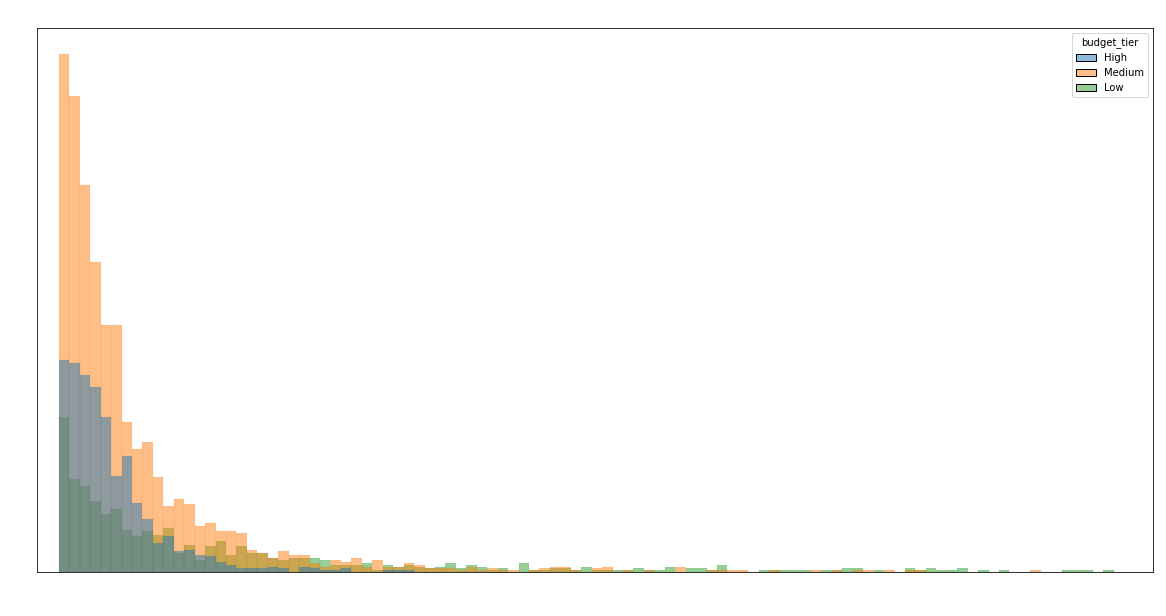

In [11]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.histplot(ax=ax, x = 'WW_success', data = WW_cleaned, stat = 'probability',hue='budget_tier')
ax.set_xlim([0,50])
ax.set_xlabel('World Wide Return (WW_Success)', fontsize = 15, color='white')
ax.set_ylabel('')
ax.set_title('Success Metrics Distribution for Population of Films', fontfamily = 'Arial', fontsize = 20, color='white')
ax.tick_params(colors='white')

#### Writer Recommendations by for low budget films

In [12]:
WW_cleaned_principals_low=WW_cleaned_principals[(WW_cleaned_principals['budget_tier']=='Low')]
WW_cleaned_principals_low.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3404 entries, 351 to 18318
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              3404 non-null   int64  
 1   title                   3404 non-null   object 
 2   studio                  936 non-null    object 
 3   foreign_gross           3404 non-null   float64
 4   year                    936 non-null    float64
 5   id                      3404 non-null   float64
 6   release_date            3404 non-null   object 
 7   production_budget       3404 non-null   float64
 8   domestic_gross_y        3404 non-null   float64
 9   worldwide_gross         3404 non-null   float64
 10  domestic_success        3404 non-null   float64
 11  foreign_success         3404 non-null   float64
 12  WW_success              3404 non-null   float64
 13  budget_tier             3404 non-null   object 
 14  movie_id                2874 non-null

In [13]:
WW_cleaned_writer_low=WW_cleaned_principals[(WW_cleaned_principals['budget_tier']=='Low')& (WW_cleaned_principals['category']=='writer')]

In [14]:
WW_cleaned_writer_low['principal_primary_name'].value_counts()[0:10]

Oren Peli             5
Christopher Landon    3
Rick Alvarez          3
Guillermo Amoedo      2
Huck Botko            2
Andrew Gurland        2
Stephen Kendrick      2
Drew Dowdle           2
Eric Heisserer        2
Damien Chazelle       2
Name: principal_primary_name, dtype: int64

In [15]:
writers_low=list(WW_cleaned_writer_low['principal_primary_name'].value_counts()[0:10].index)

In [16]:
WW_cleaned_writer_low_top=WW_cleaned_writer_low[WW_cleaned_writer_low['principal_primary_name'].isin(writers_low)]

In [17]:
WW_cleaned_writer_low_top.groupby(by='principal_primary_name').mean().sort_values(by='WW_success',ascending=False)

,Unnamed: 0,foreign_gross,year,id,production_budget,domestic_gross_y,worldwide_gross,domestic_success,foreign_success,WW_success,start_year,runtime_minutes,averagerating,numvotes,principal_death_year
principal_primary_name,,,,,,,,,,,,,,,
Christopher Landon,345.666667,94900000.0,2011.000000,58.333333,4.333333e+06,8.089402e+07,1.757900e+08,19.945599,23.104444,43.047415,2011.000000,87.333333,5.366667,79073.0,NaN
Oren Peli,574.000000,72420000.0,2011.800000,52.600000,3.800000e+06,5.865281e+07,1.321373e+08,16.889782,19.998667,37.946987,2011.800000,86.400000,5.220000,66934.0,NaN
Andrew Gurland,2755.500000,18484702.0,2010.000000,52.500000,2.900000e+06,2.810683e+07,4.780730e+07,13.295843,8.700342,22.671616,2011.500000,87.500000,4.800000,30469.5,NaN
Huck Botko,2755.500000,18484702.0,2010.000000,52.500000,2.900000e+06,2.810683e+07,4.780730e+07,13.295843,8.700342,22.671616,2011.500000,87.500000,4.800000,30469.5,NaN
Eric Heisserer,2363.500000,40800000.0,2016.000000,36.000000,3.400000e+06,4.638667e+07,8.715551e+07,13.811470,8.160000,21.965238,2013.000000,88.000000,5.750000,93073.5,NaN
Stephen Kendrick,5650.000000,3424392.5,NaN,76.500000,2.500000e+06,5.115617e+07,5.458056e+07,19.928908,1.196769,21.125678,2013.000000,124.500000,6.750000,14651.0,NaN
Damien Chazelle,3483.500000,24184702.0,2016.000000,72.000000,4.500000e+06,4.363115e+07,6.686756e+07,9.105713,5.093675,14.009731,2014.500000,95.500000,5.600000,137753.5,NaN
Rick Alvarez,1248.333333,12400000.0,2014.333333,38.666667,3.833333e+06,2.301937e+07,3.441416e+07,7.562144,3.930000,11.231118,2014.333333,88.000000,4.433333,25194.0,NaN
Drew Dowdle,3320.000000,23850875.5,2015.000000,79.000000,5.000000e+06,2.425559e+07,4.233429e+07,4.851119,4.770175,8.466858,2014.500000,98.000000,6.500000,68557.0,NaN


In [18]:
recommended_writers_low=WW_cleaned_writer_low_top.groupby(by='principal_primary_name').mean().sort_values(by='WW_success',ascending=False).index[0:6]

In [19]:
writer_tag_low=[]

for x in WW_cleaned_principals_low['principal_primary_name'].index:
    
    if WW_cleaned_principals_low.loc[x]['principal_primary_name'] in recommended_writers_low:
        writer_tag_low.append('recommended_writers')
    else: writer_tag_low.append('others')

In [20]:
WW_cleaned_principals_low['writer_tag']=writer_tag_low
WW_cleaned_principals_low

<ipython-input-20-62eed9eb29b1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  WW_cleaned_principals_low['writer_tag']=writer_tag_low


,Unnamed: 0,title,studio,foreign_gross,year,id,release_date,production_budget,domestic_gross_y,worldwide_gross,...,start_year,runtime_minutes,genres,averagerating,numvotes,principal_id,category,principal_primary_name,principal_death_year,writer_tag
351,41,Paranormal Activity 2,Par.,92800000.0,2010.0,65.0,"Oct 20, 2010",3000000.0,84752907.0,177512032.0,...,2010.0,91.0,Horror,5.7,93122.0,nm0484907,writer,Christopher Landon,NaN,recommended_writers
352,41,Paranormal Activity 2,Par.,92800000.0,2010.0,65.0,"Oct 20, 2010",3000000.0,84752907.0,177512032.0,...,2010.0,91.0,Horror,5.7,93122.0,nm0675219,writer,Michael R. Perry,NaN,others
353,41,Paranormal Activity 2,Par.,92800000.0,2010.0,65.0,"Oct 20, 2010",3000000.0,84752907.0,177512032.0,...,2010.0,91.0,Horror,5.7,93122.0,nm2305431,writer,Oren Peli,NaN,recommended_writers
354,41,Paranormal Activity 2,Par.,92800000.0,2010.0,65.0,"Oct 20, 2010",3000000.0,84752907.0,177512032.0,...,2010.0,91.0,Horror,5.7,93122.0,nm2317082,writer,Tom Pabst,NaN,others
355,41,Paranormal Activity 2,Par.,92800000.0,2010.0,65.0,"Oct 20, 2010",3000000.0,84752907.0,177512032.0,...,2010.0,91.0,Horror,5.7,93122.0,nm0931095,director,Tod Williams,NaN,others
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18314,6353,El Mariachi,NaN,1008.0,NaN,74.0,"Feb 26, 1993",7000.0,2040920.0,2041928.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,others
18315,6354,Primer,NaN,417166.0,NaN,75.0,"Oct 8, 2004",7000.0,424760.0,841926.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,others
18316,6355,Cavite,NaN,1573.0,NaN,76.0,"May 26, 2006",7000.0,70071.0,71644.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,others
18317,6357,Following,NaN,192013.0,NaN,79.0,"Apr 2, 1999",6000.0,48482.0,240495.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,others


In [21]:
WW_cleaned_producer_low=WW_cleaned_principals[(WW_cleaned_principals['budget_tier']=='Low')& (WW_cleaned_principals['category']=='producer')]
WW_cleaned_producer_low['principal_primary_name'].value_counts()[0:10]

Jason Blum               26
Timur Bekmambetov         4
Marc Bienstock            3
David Lancaster           3
Michel Litvak             3
Matthew Kaplan            3
Michael Bay               3
Andrew Form               3
Brian Kavanaugh-Jones     3
Tyler Davidson            3
Name: principal_primary_name, dtype: int64

In [22]:
producers_low=list(WW_cleaned_producer_low['principal_primary_name'].value_counts()[0:10].index)
WW_cleaned_producer_low_top=WW_cleaned_producer_low[WW_cleaned_producer_low['principal_primary_name'].isin(producers_low)]
WW_cleaned_producer_low_top.groupby(by='principal_primary_name').mean().sort_values(by='WW_success',ascending=False)

,Unnamed: 0,foreign_gross,year,id,production_budget,domestic_gross_y,worldwide_gross,domestic_success,foreign_success,WW_success,start_year,runtime_minutes,averagerating,numvotes,principal_death_year
principal_primary_name,,,,,,,,,,,,,,,
Jason Blum,2068.115385,3.809306e+07,2014.523810,63.538462,3.492923e+06,4.627790e+07,8.481556e+07,22.905026,17.355412,39.983568,2014.615385,95.038462,5.934615,115568.153846,NaN
Marc Bienstock,1622.666667,5.784667e+07,2016.333333,39.333333,4.000000e+06,6.971663e+07,1.278615e+08,14.523547,11.583333,26.166507,2016.000000,106.333333,6.500000,154074.000000,NaN
Timur Bekmambetov,1353.250000,1.335000e+07,2015.000000,59.250000,2.250000e+06,1.714884e+07,3.112601e+07,12.454949,10.820000,23.674017,2014.500000,89.250000,5.850000,51379.500000,NaN
Andrew Form,1743.000000,2.586667e+07,2013.500000,48.000000,3.266667e+06,4.694455e+07,7.335724e+07,15.277138,6.280000,21.750498,2012.333333,89.666667,5.133333,104366.666667,NaN
Michael Bay,1743.000000,2.586667e+07,2013.500000,48.000000,3.266667e+06,4.694455e+07,7.335724e+07,15.277138,6.280000,21.750498,2012.333333,89.666667,5.133333,104366.666667,NaN
Brian Kavanaugh-Jones,2705.000000,1.071838e+07,2015.000000,59.000000,2.016667e+06,2.010506e+07,3.489580e+07,8.348115,4.589882,14.295448,2014.666667,102.333333,6.833333,120576.666667,NaN
David Lancaster,2774.000000,2.165474e+07,2014.500000,59.000000,3.433333e+06,1.347544e+07,2.794107e+07,3.149255,5.760298,7.127508,2014.333333,101.333333,7.033333,234268.333333,NaN
Michel Litvak,2774.000000,2.165474e+07,2014.500000,59.000000,3.433333e+06,1.347544e+07,2.794107e+07,3.149255,5.760298,7.127508,2014.333333,101.333333,7.033333,234268.333333,NaN
Matthew Kaplan,4039.666667,6.483110e+06,2015.000000,62.000000,4.666667e+06,1.626541e+07,2.273443e+07,3.432307,1.299034,4.728524,2016.000000,91.000000,5.333333,29797.333333,NaN


In [23]:
recommended_producers_low=WW_cleaned_producer_low_top.groupby(by='principal_primary_name').mean().sort_values(by='WW_success',ascending=False).index[0:6]
producer_tag_low=[]

for x in WW_cleaned_principals_low['principal_primary_name'].index:
    
    if WW_cleaned_principals_low.loc[x]['principal_primary_name'] in recommended_producers_low:
        producer_tag_low.append('recommended_producers')
    else: producer_tag_low.append('others')
        
WW_cleaned_principals_low['producer_tag']=producer_tag_low

<ipython-input-23-b7f806e2df70>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  WW_cleaned_principals_low['producer_tag']=producer_tag_low


In [24]:
WW_cleaned_actors_low=WW_cleaned_principals[(WW_cleaned_principals['budget_tier']=='Low')& ((WW_cleaned_principals['category']=='actor')|(WW_cleaned_principals['category']=='actress'))]
WW_cleaned_actors_low['principal_primary_name'].value_counts()[0:10]

Ethan Hawke        5
Miles Teller       3
Mark Duplass       3
John Hawkes        3
Marlon Wayans      3
Elizabeth Olsen    3
Julianne Moore     3
Essence Atkins     3
Joel Edgerton      3
Rebecca Hall       3
Name: principal_primary_name, dtype: int64

In [25]:
actors_low=list(WW_cleaned_actors_low['principal_primary_name'].value_counts()[0:10].index)
WW_cleaned_actors_low_top=WW_cleaned_actors_low[WW_cleaned_actors_low['principal_primary_name'].isin(actors_low)]
WW_cleaned_actors_low_top.groupby(by='principal_primary_name').mean().sort_values(by='WW_success',ascending=False)

,Unnamed: 0,foreign_gross,year,id,production_budget,domestic_gross_y,worldwide_gross,domestic_success,foreign_success,WW_success,start_year,runtime_minutes,averagerating,numvotes,principal_death_year
principal_primary_name,,,,,,,,,,,,,,,
Ethan Hawke,1858.200000,1.542530e+07,2013.000000,66.200000,3.300000e+06,2.989977e+07,5.267883e+07,9.510751,4.819372,16.568156,2013.800000,116.400000,7.080000,170825.400000,NaN
Mark Duplass,4597.333333,4.834823e+06,2015.000000,75.333333,1.956667e+06,1.047000e+07,1.529074e+07,7.940213,5.170347,13.107743,2012.666667,86.333333,6.300000,58120.666667,NaN
Marlon Wayans,1248.333333,1.240000e+07,2014.333333,38.666667,3.833333e+06,2.301937e+07,3.441416e+07,7.562144,3.930000,11.231118,2014.333333,88.000000,4.433333,25194.000000,NaN
Julianne Moore,1640.333333,1.300000e+07,2012.500000,65.000000,3.600000e+06,2.178197e+07,3.461774e+07,7.770291,2.831667,10.595180,2012.333333,102.333333,6.800000,120970.666667,NaN
Essence Atkins,2660.000000,8.900000e+06,2013.500000,51.666667,2.700000e+06,1.998894e+07,2.790835e+07,7.323774,3.230000,10.297672,2012.333333,92.333333,4.466667,19660.000000,NaN
John Hawkes,487.000000,3.649333e+06,2011.000000,27.666667,1.333333e+06,5.171664e+06,1.102189e+07,4.083080,2.432667,8.333297,2011.000000,99.000000,7.100000,71118.333333,NaN
Joel Edgerton,3402.000000,8.875433e+06,2010.000000,46.000000,4.733333e+06,1.960547e+07,2.892579e+07,3.934352,1.847467,5.887744,2014.000000,104.000000,6.866667,81483.000000,NaN
Elizabeth Olsen,2304.333333,2.142444e+06,2011.500000,57.000000,2.000000e+06,5.476055e+06,9.429798e+06,3.195568,0.855204,5.274733,2011.666667,97.333333,6.000000,43311.666667,NaN
Miles Teller,2345.666667,1.295466e+07,2012.000000,39.000000,3.600000e+06,7.391345e+06,1.736367e+07,2.384758,3.828127,5.272195,2012.333333,97.333333,7.533333,265386.666667,NaN


In [26]:
recommended_actors_low=WW_cleaned_actors_low_top.groupby(by='principal_primary_name').mean().sort_values(by='WW_success',ascending=False).index[0:6]
actor_tag_low=[]

for x in WW_cleaned_principals_low['principal_primary_name'].index:
    
    if WW_cleaned_principals_low.loc[x]['principal_primary_name'] in recommended_actors_low:
        actor_tag_low.append('recommended_actors')
    else: actor_tag_low.append('others')
        
WW_cleaned_principals_low['actor_tag']=actor_tag_low

<ipython-input-26-7d3a4da958c7>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  WW_cleaned_principals_low['actor_tag']=actor_tag_low


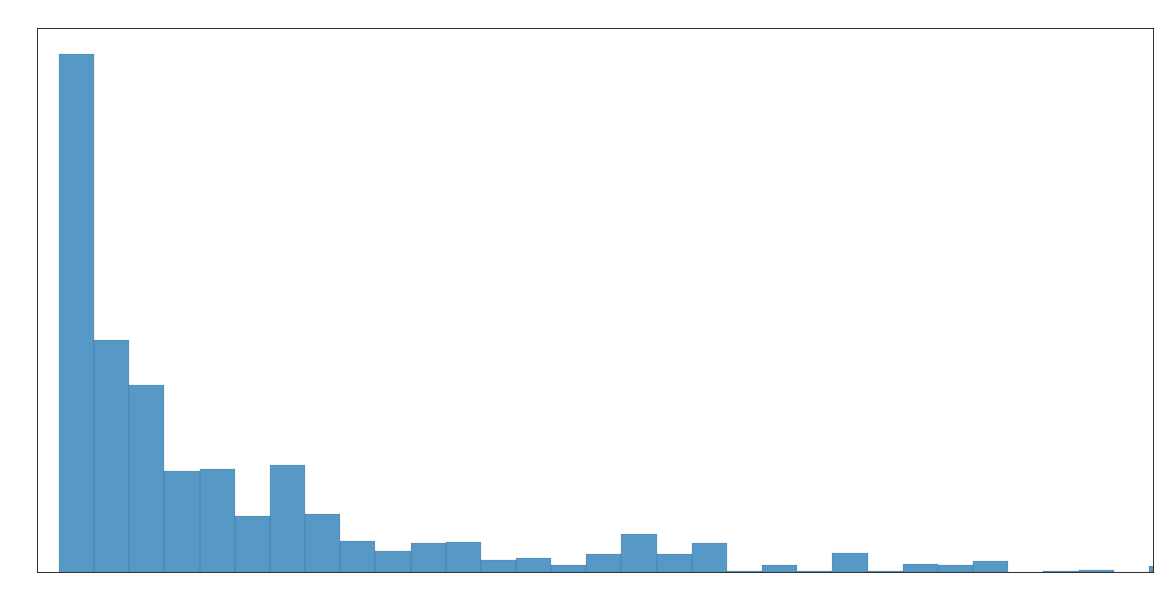

In [27]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.histplot(ax=ax, x = 'WW_success', data = WW_cleaned_principals_low, stat = 'probability')
ax.set_xlim([0,50])
ax.set_xlabel('World Wide Return (WW_Success)', fontsize = 15, color='white')
ax.set_ylabel('')
ax.set_title('Success Metrics Distribution for Low Budget Films', fontfamily = 'Arial', fontsize = 20, color='white')
ax.tick_params(colors='white')
plt.show()

In [28]:
recommended_writers_table_low=WW_cleaned_principals_low[WW_cleaned_principals_low['writer_tag']=='recommended_writers'].groupby('principal_primary_name').mean().loc[:,['WW_success']]
recommended_writers_table_low.sort_values(by='WW_success',ascending=False,inplace=True)
recommended_writers_table_low['WW_success']=recommended_writers_table_low['WW_success'].round(2)
recommended_writers_table_low.index.rename('Writers Recommendations',inplace=True)
recommended_writers_table_low

,WW_success
Writers Recommendations,
Oren Peli,36.76
Christopher Landon,34.47
Andrew Gurland,22.67
Huck Botko,22.67
Eric Heisserer,21.97
Stephen Kendrick,21.13


In [29]:
recommended_producers_table_low=WW_cleaned_principals_low[WW_cleaned_principals_low['producer_tag']=='recommended_producers'].groupby('principal_primary_name').mean().loc[:,['WW_success']]
recommended_producers_table_low.sort_values(by='WW_success',ascending=False,inplace=True)
recommended_producers_table_low['WW_success']=recommended_producers_table_low['WW_success'].round(2)
recommended_producers_table_low.index.rename('Producers Recommendations',inplace=True)
recommended_producers_table_low

,WW_success
Producers Recommendations,
Jason Blum,39.98
Marc Bienstock,26.17
Timur Bekmambetov,23.67
Andrew Form,21.75
Michael Bay,21.75
Brian Kavanaugh-Jones,14.30


In [30]:
recommended_actors_table_low=WW_cleaned_principals_low[WW_cleaned_principals_low['actor_tag']=='recommended_actors'].groupby('principal_primary_name').mean().loc[:,['WW_success']]
recommended_actors_table_low.sort_values(by='WW_success',ascending=False,inplace=True)
recommended_actors_table_low['WW_success']=recommended_actors_table_low['WW_success'].round(2)
recommended_actors_table_low.index.rename('Actors Recommendations',inplace=True)
recommended_actors_table_low

,WW_success
Actors Recommendations,
Ethan Hawke,16.57
Mark Duplass,13.11
Marlon Wayans,11.23
Julianne Moore,10.60
Essence Atkins,10.30
John Hawkes,8.33


#### Recommendations for high budget films

In [31]:
WW_cleaned_principals_high=WW_cleaned_principals[(WW_cleaned_principals['budget_tier']=='High')]
WW_cleaned_writer_high=WW_cleaned_principals[(WW_cleaned_principals['budget_tier']=='High')& (WW_cleaned_principals['category']=='writer')]

In [32]:
WW_cleaned_writer_high['principal_primary_name'].value_counts()[0:207]

Christopher Markus       6
Mark Bomback             6
Stephen McFeely          6
John Logan               6
Christopher McQuarrie    5
                        ..
Ashley Miller            2
Joshua Sternin           2
Joe Cornish              2
Edgar Wright             2
Zack Snyder              2
Name: principal_primary_name, Length: 207, dtype: int64

In [33]:
writers_high=list(WW_cleaned_writer_high['principal_primary_name'].value_counts()[0:207].index)
WW_cleaned_writer_high_top=WW_cleaned_writer_high[WW_cleaned_writer_high['principal_primary_name'].isin(writers_high)]
WW_cleaned_writer_high_top.groupby(by='principal_primary_name').mean().sort_values(by='WW_success',ascending=False)

,Unnamed: 0,foreign_gross,year,id,production_budget,domestic_gross_y,worldwide_gross,domestic_success,foreign_success,WW_success,start_year,runtime_minutes,averagerating,numvotes,principal_death_year
principal_primary_name,,,,,,,,,,,,,,,
Cinco Paul,870.0,449500000.0,2013.40,31.0,71600000.0,272134661.0,725763457.0,3.728770,6.078356,9.864475,2013.4,92.8,6.66,218442.2,NaN
Ken Daurio,870.0,449500000.0,2013.40,31.0,71600000.0,272134661.0,725763457.0,3.728770,6.078356,9.864475,2013.4,92.8,6.66,218442.2,NaN
Scott Rosenberg,1924.0,598858598.5,2017.00,20.5,103000000.0,309010162.0,909062399.0,3.167580,5.856904,9.037746,2017.5,115.5,6.85,259070.5,NaN
Brian Lynch,1164.0,372331168.2,2013.25,50.6,84400000.0,205114312.8,580816654.6,2.622839,4.566668,7.236830,2014.4,89.8,6.30,104325.8,NaN
E.L. James,1777.5,269250000.0,2017.50,94.0,55000000.0,107420885.0,376374555.5,1.953107,4.895455,6.843174,2017.5,111.5,4.55,62799.5,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Greg Berlanti,483.0,162450000.0,2011.50,74.5,175000000.0,100135627.5,262402787.5,0.570403,0.996917,1.566406,2011.5,106.5,5.60,212305.5,NaN
Ted Griffin,212.0,63000000.0,2010.50,29.5,80000000.0,62553266.5,122997847.5,0.772831,0.781255,1.521993,2010.5,102.0,5.80,103669.5,NaN
Cory Goodman,862.0,84400000.0,2013.00,62.5,70000000.0,28252143.0,107486469.0,0.413853,1.157500,1.518902,2013.0,96.5,5.85,97219.0,NaN


In [34]:
recommended_writers_high=WW_cleaned_writer_high_top.groupby(by='principal_primary_name').mean().sort_values(by='WW_success',ascending=False).index[0:6]
writer_tag_high=[]

for x in WW_cleaned_principals_high['principal_primary_name'].index:
    
    if WW_cleaned_principals_high.loc[x]['principal_primary_name'] in recommended_writers_high:
        writer_tag_high.append('recommended_writers')
    else: writer_tag_high.append('others')
        
WW_cleaned_principals_high['writer_tag']=writer_tag_high

<ipython-input-34-b649282358a9>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  WW_cleaned_principals_high['writer_tag']=writer_tag_high


In [35]:
WW_cleaned_producer_high=WW_cleaned_principals[(WW_cleaned_principals['budget_tier']=='High')& (WW_cleaned_principals['category']=='producer')]
WW_cleaned_producer_high['principal_primary_name'].value_counts()[0:48]

Lorenzo di Bonaventura    7
Peter Chernin             7
Beau Flynn                6
Simon Kinberg             6
Kevin Feige               6
Neal H. Moritz            6
Janet Healy               6
Graham King               5
Christopher Meledandri    5
Michael De Luca           5
Robert Kulzer             5
Frank Marshall            5
Joe Roth                  5
Emma Thomas               4
Jon Jashni                4
Broderick Johnson         4
Gregory Goodman           4
Mary Parent               4
Patrick Crowley           4
David Heyman              4
Don Carmody               4
Jon Kilik                 4
Mark Canton               4
Wyck Godfrey              4
Jeremy Bolt               4
Charles Roven             4
Nina Jacobson             4
Don Murphy                3
Stacey Sher               3
Carolynne Cunningham      3
Andrew A. Kosove          3
Ian Bryce                 3
Dan Lin                   3
Bernie Goldmann           3
Michael Fottrell          3
Donald De Line      

In [36]:
producers_high=list(WW_cleaned_producer_high['principal_primary_name'].value_counts()[0:46].index)
WW_cleaned_producer_high_top=WW_cleaned_producer_high[WW_cleaned_producer_high['principal_primary_name'].isin(producers_high)]
WW_cleaned_producer_high_top.groupby(by='principal_primary_name').mean().sort_values(by='WW_success',ascending=False)

,Unnamed: 0,foreign_gross,year,id,production_budget,domestic_gross_y,worldwide_gross,domestic_success,foreign_success,WW_success,start_year,runtime_minutes,averagerating,numvotes,principal_death_year
principal_primary_name,,,,,,,,,,,,,,,
Janet Healy,1525.333333,5.194593e+08,2015.400000,43.500000,7.583333e+07,2.785407e+08,8.008063e+08,3.704345,6.926345,10.668003,2016.000000,93.166667,6.716667,1.520237e+05,NaN
Christopher Meledandri,1270.800000,3.830712e+08,2013.750000,46.400000,7.360000e+07,2.292642e+08,6.144034e+08,3.100319,5.146433,8.276575,2014.800000,95.600000,6.580000,1.372916e+05,NaN
Simon Kinberg,1742.000000,3.419660e+08,2015.500000,52.833333,9.100000e+07,2.188540e+08,5.682740e+08,2.681362,4.114293,6.888508,2015.666667,116.500000,7.300000,4.349442e+05,NaN
Jon Kilik,950.000000,3.791500e+08,2013.500000,44.250000,1.237500e+08,3.628846e+08,7.395883e+08,3.206168,3.158912,6.328910,2013.500000,137.000000,6.975000,5.005290e+05,NaN
Nina Jacobson,950.000000,3.791500e+08,2013.500000,44.250000,1.237500e+08,3.628846e+08,7.395883e+08,3.206168,3.158912,6.328910,2013.500000,137.000000,6.975000,5.005290e+05,NaN
Michael Fottrell,1089.000000,1.387674e+08,2014.333333,52.333333,1.883333e+08,2.629344e+08,1.127911e+09,1.480414,1.110137,5.991324,2014.333333,134.333333,7.066667,2.815800e+05,NaN
Dana Brunetti,1479.333333,2.167333e+08,2016.000000,93.333333,5.500000e+07,1.073261e+08,3.244658e+08,1.951383,3.940606,5.899378,2016.000000,119.000000,5.633333,1.710003e+05,NaN
Don Murphy,1072.666667,6.569333e+08,2014.333333,54.333333,1.690000e+08,2.416751e+08,8.976751e+08,1.407635,3.795215,5.193699,2014.333333,144.333333,6.266667,2.480167e+05,NaN
Tom DeSanto,1072.666667,6.569333e+08,2014.333333,54.333333,1.690000e+08,2.416751e+08,8.976751e+08,1.407635,3.795215,5.193699,2014.333333,144.333333,6.266667,2.480167e+05,NaN


In [37]:
recommended_producers_high=WW_cleaned_producer_high_top.groupby(by='principal_primary_name').mean().sort_values(by='WW_success',ascending=False).index[0:6]
producer_tag_high=[]

for x in WW_cleaned_principals_high['principal_primary_name'].index:
    
    if WW_cleaned_principals_high.loc[x]['principal_primary_name'] in recommended_producers_high:
        producer_tag_high.append('recommended_producers')
    else: producer_tag_high.append('others')
        
WW_cleaned_principals_high['producer_tag']=producer_tag_high

<ipython-input-37-6bd0ecd3858a>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  WW_cleaned_principals_high['producer_tag']=producer_tag_high


In [38]:
WW_cleaned_actors_high=WW_cleaned_principals[(WW_cleaned_principals['budget_tier']=='High')& ((WW_cleaned_principals['category']=='actor')|(WW_cleaned_principals['category']=='actress'))]
WW_cleaned_actors_high['principal_primary_name'].value_counts()[0:158]

Dwayne Johnson              13
Johnny Depp                 11
Robert Downey Jr.            9
Jennifer Lawrence            9
Ryan Reynolds                8
                            ..
Sharlto Copley               3
Henry Cavill                 3
Kevin Hart                   3
Katherine Waterston          3
Christopher Mintz-Plasse     3
Name: principal_primary_name, Length: 158, dtype: int64

In [39]:
actors_high=list(WW_cleaned_actors_high['principal_primary_name'].value_counts()[0:158].index)
WW_cleaned_actors_high_top=WW_cleaned_actors_high[WW_cleaned_actors_high['principal_primary_name'].isin(actors_high)]
WW_cleaned_actors_high_top.groupby(by='principal_primary_name').mean().sort_values(by='WW_success',ascending=False)

,Unnamed: 0,foreign_gross,year,id,production_budget,domestic_gross_y,worldwide_gross,domestic_success,foreign_success,WW_success,start_year,runtime_minutes,averagerating,numvotes,principal_death_year
principal_primary_name,,,,,,,,,,,,,,,
Kevin Hart,1845.000000,3.714186e+08,2016.5,48.333333,8.166667e+07,2.788963e+08,6.548661e+08,3.401260,4.525446,7.985620,2017.333333,97.333333,6.700000,136066.333333,NaN
Kristen Wiig,1361.800000,4.010316e+08,2014.5,27.800000,9.880000e+07,2.095422e+08,6.164172e+08,2.403541,4.809106,7.270049,2014.800000,112.200000,6.840000,315802.800000,NaN
Josh Gad,1473.000000,6.252285e+08,2014.5,56.000000,1.276667e+08,3.374205e+08,9.613325e+08,2.431469,4.637111,7.059847,2015.333333,109.333333,7.000000,274982.333333,NaN
Steve Carell,760.333333,2.933500e+08,2013.0,58.666667,6.733333e+07,1.839629e+08,4.772263e+08,2.611133,4.011705,6.618717,2013.000000,102.666667,6.800000,201734.166667,NaN
Selena Gomez,1258.666667,2.921000e+08,2015.0,71.666667,7.666667e+07,1.618378e+08,4.583620e+08,2.147678,3.946966,6.143562,2015.000000,92.333333,6.700000,113258.333333,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Ryan Gosling,1503.333333,9.573333e+07,2016.0,30.000000,1.016667e+08,6.099720e+07,1.562207e+08,0.671071,0.967928,1.630115,2016.000000,139.333333,7.366667,230603.333333,NaN
Dane DeHaan,2233.000000,8.513188e+07,2017.0,83.333333,1.010000e+08,4.680059e+07,1.285721e+08,0.606097,0.748334,1.335762,2017.000000,116.000000,6.200000,49323.000000,NaN
Harrison Ford,1664.333333,9.351861e+07,2015.0,65.666667,1.250000e+08,7.252900e+07,1.668974e+08,0.618761,0.701077,1.327437,2016.333333,121.333333,7.066667,197143.333333,NaN


In [40]:
recommended_actors_high=WW_cleaned_actors_high_top.groupby(by='principal_primary_name').mean().sort_values(by='WW_success',ascending=False).index[0:6]
actor_tag_high=[]

for x in WW_cleaned_principals_high['principal_primary_name'].index:
    
    if WW_cleaned_principals_high.loc[x]['principal_primary_name'] in recommended_actors_high:
        actor_tag_high.append('recommended_actors')
    else: actor_tag_high.append('others')
        
WW_cleaned_principals_high['actor_tag']=actor_tag_high

<ipython-input-40-4b877d9d6ac7>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  WW_cleaned_principals_high['actor_tag']=actor_tag_high


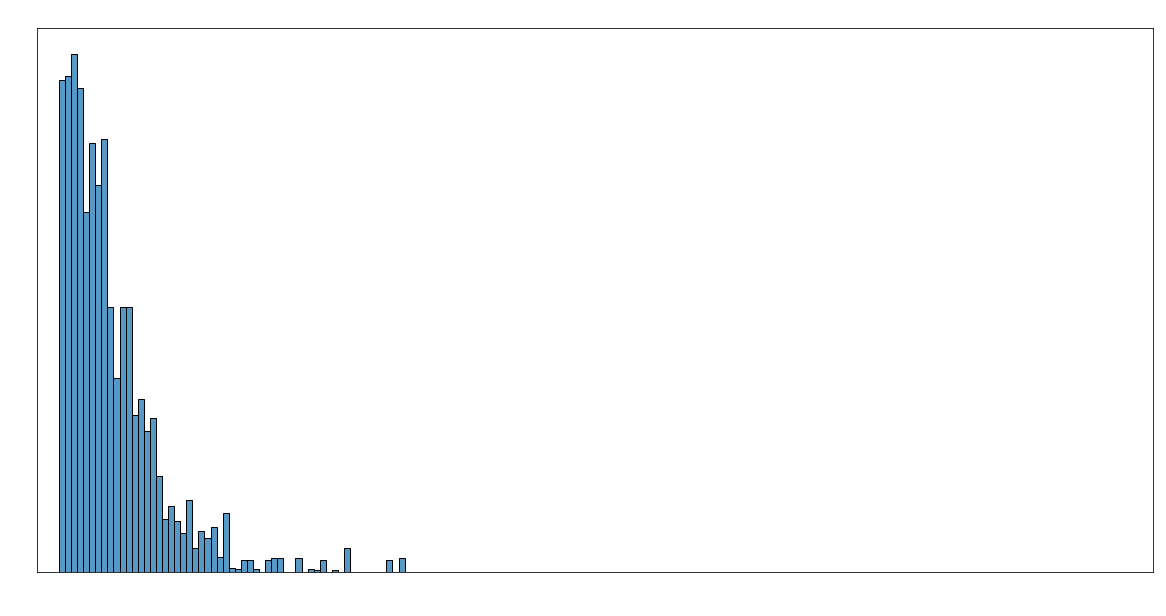

In [41]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.histplot(ax=ax, x = 'WW_success', data = WW_cleaned_principals_high, stat = 'probability')
ax.set_xlim([0,50])
ax.set_xlabel('World Wide Return (WW_Success)', fontsize = 15, color='white')
ax.set_ylabel('')
ax.set_title('Success Metrics Distribution for High Budget Films', fontfamily = 'Arial', fontsize = 20, color='white')
ax.tick_params(colors='white')

plt.show()

In [42]:
recommended_writers_table_high=WW_cleaned_principals_high[WW_cleaned_principals_high['writer_tag']=='recommended_writers'].groupby('principal_primary_name').mean().loc[:,['WW_success']]
recommended_writers_table_high.sort_values(by='WW_success',ascending=False,inplace=True)
recommended_writers_table_high['WW_success']=recommended_writers_table_high['WW_success'].round(2)
recommended_writers_table_high.index.rename('Writers Recommendations',inplace=True)
recommended_writers_table_high

,WW_success
Writers Recommendations,
Cinco Paul,9.86
Ken Daurio,9.86
Scott Rosenberg,9.04
Brian Lynch,7.24
E.L. James,6.84
Niall Leonard,6.84


In [43]:
recommended_producers_table_high=WW_cleaned_principals_high[WW_cleaned_principals_high['producer_tag']=='recommended_producers'].groupby('principal_primary_name').mean().loc[:,['WW_success']]
recommended_producers_table_high.sort_values(by='WW_success',ascending=False,inplace=True)
recommended_producers_table_high['WW_success']=recommended_producers_table_high['WW_success'].round(2)
recommended_producers_table_high.index.rename('Producers Recommendations',inplace=True)
recommended_producers_table_high

,WW_success
Producers Recommendations,
Janet Healy,10.67
Christopher Meledandri,8.28
Jon Kilik,6.33
Nina Jacobson,6.33
Michael Fottrell,5.99
Simon Kinberg,5.07


In [44]:
recommended_actors_table_high=WW_cleaned_principals_high[WW_cleaned_principals_high['actor_tag']=='recommended_actors'].groupby('principal_primary_name').mean().loc[:,['WW_success']]
recommended_actors_table_high.sort_values(by='WW_success',ascending=False,inplace=True)
recommended_actors_table_high['WW_success']=recommended_actors_table_high['WW_success'].round(2)
recommended_actors_table_high.index.rename('Actors Recommendations',inplace=True)
recommended_actors_table_high

,WW_success
Actors Recommendations,
Kevin Hart,7.99
Kristen Wiig,7.27
Josh Gad,7.06
Steve Carell,6.62
Selena Gomez,6.14
Josh Hutcherson,5.33


#### Recommendations for mid budget films

In [45]:
WW_cleaned_principals_mid=WW_cleaned_principals[(WW_cleaned_principals['budget_tier']=='Medium')]
WW_cleaned_writer_mid=WW_cleaned_principals[(WW_cleaned_principals['budget_tier']=='Medium')& (WW_cleaned_principals['category']=='writer')]

In [46]:
WW_cleaned_writer_mid['principal_primary_name'].value_counts()[0:146]

Luc Besson           7
Robert Mark Kamen    6
John Morris          6
Nicholas Sparks      6
Nicholas Stoller     5
                    ..
Vijayendra Prasad    2
Matt Cook            2
John Hamburg         2
Akiva Goldsman       2
Joshua Zetumer       2
Name: principal_primary_name, Length: 146, dtype: int64

In [47]:
writers_mid=list(WW_cleaned_writer_mid['principal_primary_name'].value_counts().index[0:146])

In [48]:
WW_cleaned_writer_mid_top=WW_cleaned_writer_mid[WW_cleaned_writer_mid['principal_primary_name'].isin(writers_mid)]

In [49]:
WW_cleaned_writer_mid_top.groupby(by='principal_primary_name').mean().sort_values(by='WW_success',ascending=False)

,Unnamed: 0,foreign_gross,year,id,production_budget,domestic_gross_y,worldwide_gross,domestic_success,foreign_success,WW_success,start_year,runtime_minutes,averagerating,numvotes,principal_death_year
principal_primary_name,,,,,,,,,,,,,,,
Gary Dauberman,1483.333333,2.500333e+08,2016.0,36.666667,1.883333e+07,1.712826e+08,419901918.0,9.709323,16.955189,26.601245,2016.0,114.333333,6.433333,190521.333333,NaN
Reid Carolin,992.500000,5.500000e+07,2013.5,77.000000,1.075000e+07,8.986731e+07,147105175.0,10.399282,5.769704,16.446284,2013.5,112.500000,5.850000,86226.000000,NaN
John Green,2937.500000,1.178972e+08,2015.0,55.500000,1.200000e+07,7.843633e+07,196308659.0,6.536361,9.824770,16.359055,2014.5,117.500000,7.000000,201438.500000,NaN
Jeff Fradley,4249.500000,5.740195e+07,NaN,25.500000,1.250000e+07,1.088056e+08,166207534.0,9.909406,5.419441,15.328847,2018.0,106.000000,6.600000,88395.000000,NaN
John J. McLaughlin,488.500000,1.255000e+08,2011.5,32.000000,2.400000e+07,6.228566e+07,189905049.0,4.365308,8.962418,13.434504,2011.5,113.000000,7.100000,377191.500000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Siddharth Singh,3566.500000,1.684986e+07,NaN,24.500000,1.950000e+07,1.460042e+07,31450279.0,0.574183,0.978841,1.553024,2015.0,156.000000,6.700000,10689.000000,NaN
Ekta Pathak Malhotra,3566.500000,1.684986e+07,NaN,24.500000,1.950000e+07,1.460042e+07,31450279.0,0.574183,0.978841,1.553024,2015.0,156.000000,6.700000,10689.000000,NaN
Gavin O'Connor,3566.500000,1.684986e+07,NaN,24.500000,1.950000e+07,1.460042e+07,31450279.0,0.574183,0.978841,1.553024,2015.0,156.000000,6.700000,10689.000000,NaN


In [50]:
recommended_writers_mid=WW_cleaned_writer_mid_top.groupby(by='principal_primary_name').mean().sort_values(by='WW_success',ascending=False).index[0:6]

In [51]:
writer_tag_mid=[]

for x in WW_cleaned_principals_mid['principal_primary_name'].index:
    
    if WW_cleaned_principals_mid.loc[x]['principal_primary_name'] in recommended_writers_mid:
        writer_tag_mid.append('recommended_writers')
    else: writer_tag_mid.append('others')

In [52]:
WW_cleaned_principals_mid['writer_tag']=writer_tag_mid

<ipython-input-52-85cd7d1d44ab>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  WW_cleaned_principals_mid['writer_tag']=writer_tag_mid


In [53]:
WW_cleaned_producer_mid=WW_cleaned_principals[(WW_cleaned_principals['budget_tier']=='Medium')& (WW_cleaned_principals['category']=='producer')]
WW_cleaned_producer_mid['principal_primary_name'].value_counts()[0:60]

Tim Bevan                 14
Eric Fellner              13
Jason Blum                11
Marty Bowen                9
Broderick Johnson          8
Scott Rudin                8
Wyck Godfrey               8
Will Packer                8
Sidney Kimmel              7
Michael Bay                7
Marc Platt                 7
Peter Chernin              7
Andrew A. Kosove           7
Roy Lee                    6
Lorenzo di Bonaventura     6
Andrew Form                6
Jenno Topping              6
Peter Safran               6
Evan Goldberg              6
Todd Garner                6
Ryan Kavanaugh             6
Dede Gardner               6
Todd Black                 6
Nina Jacobson              5
Anthony Bregman            5
Megan Ellison              5
Brad Fuller                5
Anthony Katagas            5
Chris Bender               5
Gary Lucchesi              5
Brian Grazer               5
Brian Oliver               5
Michael De Luca            5
Shawn Levy                 5
Judd Apatow   

In [54]:
producers_mid=list(WW_cleaned_producer_mid['principal_primary_name'].value_counts()[0:60].index)
WW_cleaned_producer_mid_top=WW_cleaned_producer_mid[WW_cleaned_producer_mid['principal_primary_name'].isin(producers_mid)]
WW_cleaned_producer_mid_top.groupby(by='principal_primary_name').mean().sort_values(by='WW_success',ascending=False)

,Unnamed: 0,foreign_gross,year,id,production_budget,domestic_gross_y,worldwide_gross,domestic_success,foreign_success,WW_success,start_year,runtime_minutes,averagerating,numvotes,principal_death_year
principal_primary_name,,,,,,,,,,,,,,,
Peter Safran,1804.333333,1.052484e+08,2013.500000,44.500000,1.791667e+07,7.310315e+07,1.780258e+08,5.279432,8.820969,14.077385,2014.666667,103.333333,5.533333,120193.666667,NaN
Brad Fuller,1564.000000,6.214000e+07,2016.200000,62.400000,1.220000e+07,8.609327e+07,1.468197e+08,6.824707,4.695841,11.434699,2016.200000,101.000000,6.320000,124945.800000,NaN
Andrew Form,1835.833333,6.089244e+07,2016.200000,60.166667,1.600000e+07,8.225689e+07,1.419714e+08,5.987613,4.173461,10.089533,2015.166667,100.000000,6.133333,118371.000000,NaN
Michael Bay,1796.285714,5.885066e+07,2016.166667,62.285714,1.500000e+07,7.552655e+07,1.333800e+08,5.690089,4.316934,9.947090,2015.285714,99.857143,6.128571,108189.285714,NaN
Jason Blum,2596.000000,5.862357e+07,2016.428571,62.545455,1.227273e+07,6.600923e+07,1.247061e+08,5.141751,4.741057,9.891758,2017.000000,108.727273,6.318182,83258.000000,NaN
Peter Czernin,1821.750000,6.334454e+07,2013.000000,55.750000,1.137500e+07,3.724992e+07,1.045629e+08,3.400474,5.865610,9.574707,2013.750000,117.750000,7.325000,170570.500000,NaN
Graham Broadbent,1821.750000,6.334454e+07,2013.000000,55.750000,1.137500e+07,3.724992e+07,1.045629e+08,3.400474,5.865610,9.574707,2013.750000,117.750000,7.325000,170570.500000,NaN
Nick Wechsler,1439.750000,5.046334e+07,2013.333333,70.000000,2.412500e+07,5.583301e+07,1.074242e+08,5.502496,3.614119,9.255620,2013.250000,116.750000,5.725000,92545.250000,NaN
Gregory Jacobs,1636.000000,3.079235e+07,2013.666667,56.000000,2.225000e+07,4.815384e+07,7.948272e+07,4.774958,2.533762,7.424213,2013.250000,106.750000,6.500000,119267.000000,NaN


In [55]:
recommended_producers_mid=WW_cleaned_producer_mid_top.groupby(by='principal_primary_name').mean().sort_values(by='WW_success',ascending=False).index[0:6]
producer_tag_mid=[]

for x in WW_cleaned_principals_mid['principal_primary_name'].index:
    
    if WW_cleaned_principals_mid.loc[x]['principal_primary_name'] in recommended_producers_mid:
        producer_tag_mid.append('recommended_producers')
    else: producer_tag_mid.append('others')
        
WW_cleaned_principals_mid['producer_tag']=producer_tag_mid

<ipython-input-55-185b555999ba>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  WW_cleaned_principals_mid['producer_tag']=producer_tag_mid


In [56]:
WW_cleaned_actors_mid=WW_cleaned_principals[(WW_cleaned_principals['budget_tier']=='Medium')& ((WW_cleaned_principals['category']=='actor')|(WW_cleaned_principals['category']=='actress'))]
WW_cleaned_actors_mid['principal_primary_name'].value_counts()[0:119]

Kevin Hart        12
Liam Neeson       11
Seth Rogen        10
Channing Tatum    10
Mark Wahlberg      9
                  ..
Russell Crowe      4
Jackie Chan        4
Jamie Bell         4
Jason Segel        4
Tom Hardy          4
Name: principal_primary_name, Length: 119, dtype: int64

In [57]:
actors_mid=list(WW_cleaned_actors_mid['principal_primary_name'].value_counts()[0:119].index)
WW_cleaned_actors_mid_top=WW_cleaned_actors_mid[WW_cleaned_actors_mid['principal_primary_name'].isin(actors_mid)]
WW_cleaned_actors_mid_top.groupby(by='principal_primary_name').mean().sort_values(by='WW_success',ascending=False)

,Unnamed: 0,foreign_gross,year,id,production_budget,domestic_gross_y,worldwide_gross,domestic_success,foreign_success,WW_success,start_year,runtime_minutes,averagerating,numvotes,principal_death_year
principal_primary_name,,,,,,,,,,,,,,,
Mila Kunis,847.80,1.551600e+08,2013.200000,64.800000,2.920000e+07,1.133582e+08,2.685177e+08,4.486642,6.403510,10.880374,2013.20,105.40,6.640,327713.400000,NaN
Maggie Smith,1088.75,5.395000e+07,2013.750000,66.250000,9.250000e+06,2.696786e+07,8.088088e+07,2.822014,5.824924,8.665750,2013.25,111.00,6.850,38956.500000,NaN
Emma Stone,809.00,8.230000e+07,2013.000000,59.833333,2.133333e+07,7.601015e+07,1.551411e+08,4.248593,4.361611,8.426017,2013.00,111.00,6.550,230194.666667,NaN
Bill Nighy,1755.00,5.714329e+07,2013.333333,58.000000,1.250000e+07,2.796208e+07,8.621723e+07,2.542775,5.265461,7.910316,2013.75,114.75,6.325,96457.250000,NaN
Octavia Spencer,2039.20,5.263997e+07,2015.250000,46.000000,1.710000e+07,8.990894e+07,1.399236e+08,4.557437,2.782177,7.111622,2015.00,123.60,7.480,193005.400000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Jamie Bell,1319.25,4.217500e+07,2012.333333,53.000000,3.700000e+07,2.500395e+07,7.133190e+07,0.683903,1.066841,1.898194,2013.75,115.75,6.900,115628.000000,NaN
Akshay Kumar,3141.75,1.229951e+07,2010.000000,23.750000,1.367500e+07,7.692481e+06,2.407766e+07,0.333596,1.157442,1.895559,2013.00,149.25,5.825,9528.750000,NaN
Kate Winslet,2815.50,3.294623e+07,2015.500000,34.250000,2.572500e+07,1.333789e+07,4.576047e+07,0.431393,1.356721,1.775114,2014.25,104.50,7.075,93909.250000,NaN


In [58]:
recommended_actors_mid=WW_cleaned_actors_mid_top.groupby(by='principal_primary_name').mean().sort_values(by='WW_success',ascending=False).index[0:6]
actor_tag_mid=[]

for x in WW_cleaned_principals_mid['principal_primary_name'].index:
    
    if WW_cleaned_principals_mid.loc[x]['principal_primary_name'] in recommended_actors_mid:
        actor_tag_mid.append('recommended_actors')
    else: actor_tag_mid.append('others')
        
WW_cleaned_principals_mid['actor_tag']=actor_tag_mid

<ipython-input-58-a03fafe9b5f6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  WW_cleaned_principals_mid['actor_tag']=actor_tag_mid


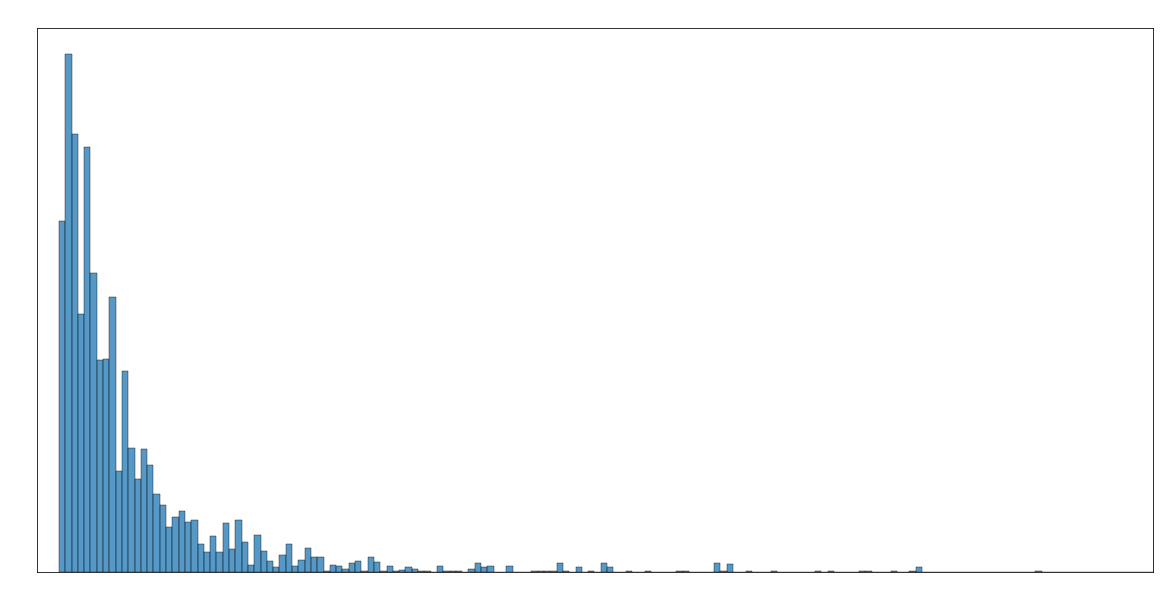

In [59]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.histplot(ax=ax, x = 'WW_success', data = WW_cleaned_principals_mid, stat = 'probability')
ax.set_xlim([0,50])
ax.set_xlabel('World Wide Return (WW_Success)', fontsize = 15, color='white')
ax.set_ylabel('')
ax.set_title('Success Metrics Distribution for Medium Budget Films', fontfamily = 'Arial', fontsize = 20, color='white')
ax.tick_params(colors='white')
plt.show()

In [60]:
recommended_writers_table_mid=WW_cleaned_principals_mid[WW_cleaned_principals_mid['writer_tag']=='recommended_writers'].groupby('principal_primary_name').mean().loc[:,['WW_success']]
recommended_writers_table_mid.sort_values(by='WW_success',ascending=False,inplace=True)
recommended_writers_table_mid['WW_success']=recommended_writers_table_mid['WW_success'].round(2)
recommended_writers_table_mid.index.rename('Writers Recommendations',inplace=True)
recommended_writers_table_mid

,WW_success
Writers Recommendations,
Gary Dauberman,26.60
John Green,16.36
Jeff Fradley,15.33
John J. McLaughlin,13.43
Michael H. Weber,11.86
Reid Carolin,11.47


In [61]:
recommended_producers_table_mid=WW_cleaned_principals_mid[WW_cleaned_principals_mid['producer_tag']=='recommended_producers'].groupby('principal_primary_name').mean().loc[:,['WW_success']]
recommended_producers_table_mid.sort_values(by='WW_success',ascending=False,inplace=True)
recommended_producers_table_mid['WW_success']=recommended_producers_table_mid['WW_success'].round(2)
recommended_producers_table_mid.index.rename('Producers Recommendations',inplace=True)
recommended_producers_table_mid

,WW_success
Producers Recommendations,
Peter Safran,14.08
Brad Fuller,11.43
Andrew Form,10.09
Jason Blum,9.89
Peter Czernin,9.57
Michael Bay,9.09


In [62]:
recommended_actors_table_mid=WW_cleaned_principals_mid[WW_cleaned_principals_mid['actor_tag']=='recommended_actors'].groupby('principal_primary_name').mean().loc[:,['WW_success']]
recommended_actors_table_mid.sort_values(by='WW_success',ascending=False,inplace=True)
recommended_actors_table_mid['WW_success']=recommended_actors_table_mid['WW_success'].round(2)
recommended_actors_table_mid.index.rename('Actors Recommendations',inplace=True)
recommended_actors_table_mid

,WW_success
Actors Recommendations,
Mila Kunis,10.88
Maggie Smith,8.67
Emma Stone,8.43
Bill Nighy,7.91
Octavia Spencer,7.11
Emily Blunt,6.82


Hypo testing 

Given the the dataset for each budget tier is large enough (thousands) and the central limit therum, we are conducting one sample t-test using our recommended samples and the population mean.Below we find that we are not as statistically confident for the recommendation for low budget films due to the highly variable nature of the population distribution

In [63]:
writer_low_samples=WW_cleaned_principals_low[WW_cleaned_principals_low['writer_tag']=='recommended_writers']['WW_success']
producer_low_samples=WW_cleaned_principals_low[WW_cleaned_principals_low['producer_tag']=='recommended_producers']['WW_success']
actor_low_samples=WW_cleaned_principals_low[WW_cleaned_principals_low['actor_tag']=='recommended_actors']['WW_success']
writer_high_samples=WW_cleaned_principals_high[WW_cleaned_principals_high['writer_tag']=='recommended_writers']['WW_success']
producer_high_samples=WW_cleaned_principals_high[WW_cleaned_principals_high['producer_tag']=='recommended_producers']['WW_success']
actor_high_samples=WW_cleaned_principals_high[WW_cleaned_principals_high['actor_tag']=='recommended_actors']['WW_success']
writer_mid_samples=WW_cleaned_principals_mid[WW_cleaned_principals_mid['writer_tag']=='recommended_writers']['WW_success']
producer_mid_samples=WW_cleaned_principals_mid[WW_cleaned_principals_mid['producer_tag']=='recommended_producers']['WW_success']
actor_mid_samples=WW_cleaned_principals_mid[WW_cleaned_principals_mid['actor_tag']=='recommended_actors']['WW_success']

In [64]:
#defining the population data for each budget tier movie for further hypothesis testing against the success metric of the samples from our talent recommendation 
population_mean_low=WW_cleaned_principals_low['WW_success'].mean()
population_mean_mid=WW_cleaned_principals_mid['WW_success'].mean()
population_mean_high=WW_cleaned_principals_high['WW_success'].mean()

In [65]:
stats.ttest_1samp(writer_low_samples,population_mean_low)

Ttest_1sampResult(statistic=2.9356214944315937, pvalue=0.008486704752726356)

In [66]:
stats.ttest_1samp(producer_low_samples,population_mean_low)

Ttest_1sampResult(statistic=1.4945681156108426, pvalue=0.14268458599239084)

In [67]:
stats.ttest_1samp(actor_low_samples,population_mean_low)

Ttest_1sampResult(statistic=-2.9674504671200426, pvalue=0.007911192312965065)

In [68]:
stats.ttest_1samp(writer_high_samples,population_mean_high)

Ttest_1sampResult(statistic=5.72601292714263, pvalue=1.3275709789689439e-05)

In [69]:
stats.ttest_1samp(producer_high_samples,population_mean_high)

Ttest_1sampResult(statistic=4.988553659757353, pvalue=2.054383891916128e-05)

In [70]:
stats.ttest_1samp(actor_high_samples,population_mean_high)

Ttest_1sampResult(statistic=4.077692193556613, pvalue=0.00040573014258596954)

In [71]:
stats.ttest_1samp(writer_mid_samples,population_mean_mid)

Ttest_1sampResult(statistic=3.876419738645971, pvalue=0.0016778764051453203)

In [72]:
stats.ttest_1samp(producer_mid_samples,population_mean_mid)

Ttest_1sampResult(statistic=5.63550533693335, pvalue=1.661178545049509e-06)

In [73]:
stats.ttest_1samp(actor_mid_samples,population_mean_mid)

Ttest_1sampResult(statistic=3.7759594267211325, pvalue=0.0007636660505038193)

In [74]:
WW_cleaned['release_month']=pd.to_datetime(WW_cleaned['release_date']).dt.strftime('%m')
WW_cleaned_principals_low['release_month']=pd.to_datetime(WW_cleaned_principals_low['release_date']).dt.strftime('%m')
WW_cleaned_principals_mid['release_month']=pd.to_datetime(WW_cleaned_principals_mid['release_date']).dt.strftime('%m')
WW_cleaned_principals_high['release_month']=pd.to_datetime(WW_cleaned_principals_high['release_date']).dt.strftime('%m')

<ipython-input-74-e89f243d1a92>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  WW_cleaned_principals_low['release_month']=pd.to_datetime(WW_cleaned_principals_low['release_date']).dt.strftime('%m')
<ipython-input-74-e89f243d1a92>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  WW_cleaned_principals_mid['release_month']=pd.to_datetime(WW_cleaned_principals_mid['release_date']).dt.strftime('%m')
<ipython-input-74-e89f243d1a92>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

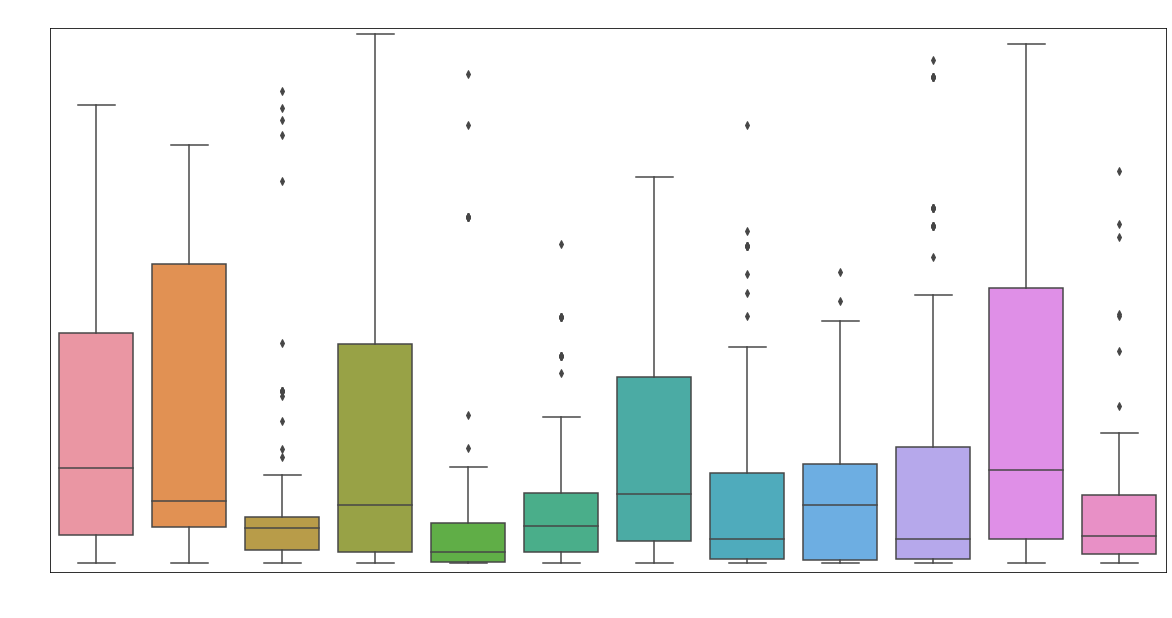

In [75]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.boxplot(ax=ax,x='release_month',y='WW_success',data=WW_cleaned_principals_low,order=['01','02','03','04','05','06','07','08','09','10','11','12'])
ax.set_ylim([0,65])
ax.set_xlabel('Release Month', fontsize = 15, color='white')
ax.set_ylabel('World Wide Return (WW_Success)',fontsize = 15, color='white')
ax.set_title('Success Metrics Distribution by Month for Low Budget Films', fontfamily = 'Arial', fontsize = 20, color='white')
ax.tick_params(labelsize='large',colors='white')
plt.show()

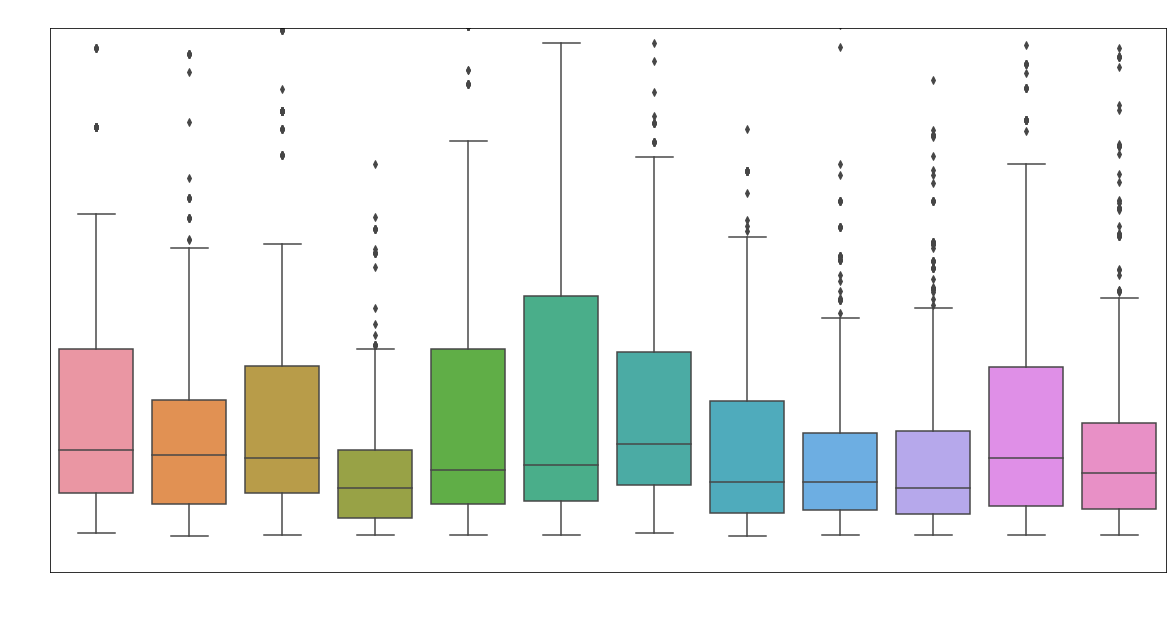

In [76]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.boxplot(ax=ax,x='release_month',y='WW_success',data=WW_cleaned_principals_mid,order=['01','02','03','04','05','06','07','08','09','10','11','12'])
ax.set_ylim([0,15])
ax.set_xlabel('Release Month', fontsize = 15, color='white')
ax.set_ylabel('World Wide Return (WW_Success)',fontsize = 15, color='white')
ax.set_title('Success Metrics Distribution by Month for Medium Budget Films', fontfamily = 'Arial', fontsize = 20, color='white')
ax.tick_params(labelsize='large',colors='white')
plt.show()

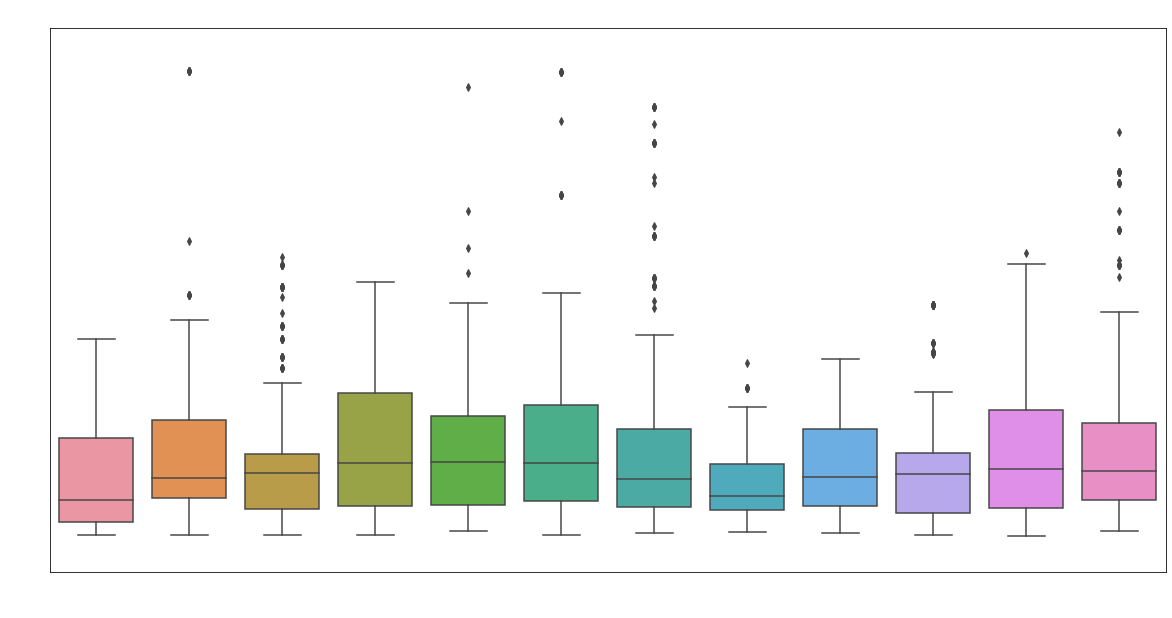

In [77]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.boxplot(ax=ax,x='release_month',y='WW_success',data=WW_cleaned_principals_high,order=['01','02','03','04','05','06','07','08','09','10','11','12'])
ax.set_ylim([0,15])
ax.set_xlabel('Release Month', fontsize = 15, color='white')
ax.set_ylabel('World Wide Return (WW_Success)',fontsize = 15, color='white')
ax.set_title('Success Metrics Distribution by Month for High Budget Films', fontfamily = 'Arial', fontsize = 20, color='white')
ax.tick_params(labelsize='large',colors='white')
plt.show()

(0.0, 15.0)

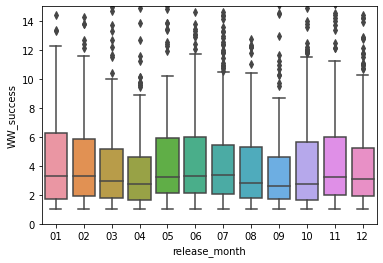

In [78]:
sns.boxplot(x='release_month',y='WW_success',data=WW_cleaned,order=['01','02','03','04','05','06','07','08','09','10','11','12'])
ax=plt.gca()
ax.set_ylim([0,15])

In [79]:
WW_cleaned.groupby('release_month').mean()
WW_cleaned_high=WW_cleaned[WW_cleaned['budget_tier']=='High']
WW_cleaned_mid=WW_cleaned[WW_cleaned['budget_tier']=='Medium']
WW_cleaned_low=WW_cleaned[WW_cleaned['budget_tier']=='Low']